In [1]:
from tsfresh.examples import load_driftbif
from tsfresh.feature_extraction import ComprehensiveFCParameters
from tsfresh.feature_extraction.settings import get_aggregate_functions, get_apply_functions
import pandas as pd
import pprint
import timeit
from tqdm import tqdm
import matplotlib.pylab as plt
import seaborn as sns

/Users/mchrist/Documents/Research/tsfresh/venv/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/Users/mchrist/Documents/Research/tsfresh/venv/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
# load data
X, _ = load_driftbif(10, 1000)
X.drop("dimension", axis=1, inplace=True)

In [3]:
# get all the parameters and respective functions
settings = ComprehensiveFCParameters()
settings

{'abs_energy': None,
 'absolute_sum_of_changes': None,
 'approximate_entropy': [{'m': 2, 'r': 0.1},
  {'m': 2, 'r': 0.3},
  {'m': 2, 'r': 0.5},
  {'m': 2, 'r': 0.7},
  {'m': 2, 'r': 0.9}],
 'ar_coefficient': [{'coeff': 0, 'k': 10},
  {'coeff': 1, 'k': 10},
  {'coeff': 2, 'k': 10},
  {'coeff': 3, 'k': 10},
  {'coeff': 4, 'k': 10}],
 'augmented_dickey_fuller': None,
 'autocorrelation': [{'lag': 0},
  {'lag': 1},
  {'lag': 2},
  {'lag': 3},
  {'lag': 4},
  {'lag': 5},
  {'lag': 6},
  {'lag': 7},
  {'lag': 8},
  {'lag': 9}],
 'binned_entropy': [{'max_bins': 10}],
 'count_above_mean': None,
 'count_below_mean': None,
 'cwt_coefficients': [{'coeff': 0, 'w': 2, 'widths': (2, 5, 10, 20)},
  {'coeff': 0, 'w': 5, 'widths': (2, 5, 10, 20)},
  {'coeff': 0, 'w': 10, 'widths': (2, 5, 10, 20)},
  {'coeff': 0, 'w': 20, 'widths': (2, 5, 10, 20)},
  {'coeff': 1, 'w': 2, 'widths': (2, 5, 10, 20)},
  {'coeff': 1, 'w': 5, 'widths': (2, 5, 10, 20)},
  {'coeff': 1, 'w': 10, 'widths': (2, 5, 10, 20)},
  {'coe

In [4]:
column_name_to_aggregate_function = get_aggregate_functions(settings, "value")
apply_functions = get_apply_functions(settings, "value")

In [5]:
# compare performance of tsfresh for aggregate features that are calculated individually
res  = pd.DataFrame()
n_ts = 20
l_ts = 1000
n_ti = 10

group = X.groupby("id")["value"]

for col, f in tqdm(column_name_to_aggregate_function.items()):
    res.loc[col, "feature"] = col
    res.loc[col, "n_samp"] = n_ts
    res.loc[col, "length"] = l_ts
    t = timeit.timeit(lambda : group.aggregate(f), number=n_ti)
    res.loc[col, "t_abs"] = t
    res.loc[col, "t_1ts"] = t*1.0/n_ts

100%|██████████| 112/112 [12:38<00:00,  6.77s/it] 


In [6]:
res["feature"] = res.feature.astype(str)
res = res.sort_values(by="feature")

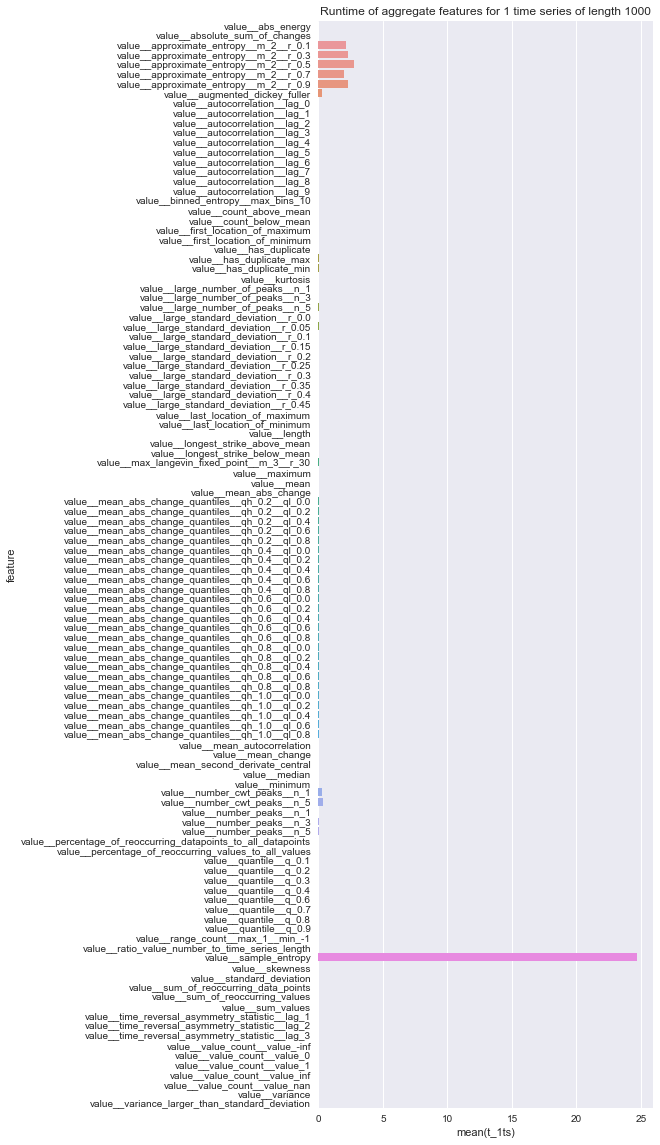

In [7]:
# compare performance of tsfresh for aggregate features that are calculated in groups
plt.figure(figsize=(6,20))
sns.barplot(y="feature", x="t_1ts", data=res)
plt.title("Runtime of aggregate features for 1 time series of length 1000")
plt.show()

In [8]:
# compare performance of tsfresh for apply features that are calculated in groups
res2  = pd.DataFrame()
n_ts = 20
l_ts = 1000
n_ti = 10

group = X.groupby("id")["value"]

for f, kwargs in tqdm(apply_functions):
    col = f.func_name
    res2.loc[col, "feature"] = col
    res2.loc[col, "n_samp"] = n_ts
    res2.loc[col, "length"] = l_ts
    t = timeit.timeit(lambda : group.apply(f, **kwargs).unstack(), number=n_ti)
    
    # apply features return more than one feature at a time, hence we have to devide by number of features
    n_fs = len(kwargs["param"])
    res2.loc[col, "n_fs"] = n_fs
    res2.loc[col, "t_abs"] = t * 1.0/ n_fs
    res2.loc[col, "t_1ts"] = t*1.0/(n_ts*n_fs)

100%|██████████| 7/7 [00:01<00:00,  4.51it/s]


In [9]:
res2

,feature,n_samp,length,n_fs,t_abs,t_1ts
friedrich_coefficients,friedrich_coefficients,20.0,1000.0,4.0,0.186667,0.009333
ar_coefficient,ar_coefficient,20.0,1000.0,5.0,0.063314,0.003166
index_mass_quantile,index_mass_quantile,20.0,1000.0,8.0,0.008437,0.000422
cwt_coefficients,cwt_coefficients,20.0,1000.0,60.0,0.002484,0.000124
symmetry_looking,symmetry_looking,20.0,1000.0,20.0,0.004108,0.000205
fft_coefficient,fft_coefficient,20.0,1000.0,10.0,0.005021,0.000251
spkt_welch_density,spkt_welch_density,20.0,1000.0,3.0,0.026646,0.001332


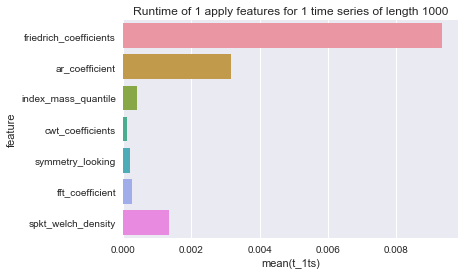

In [10]:
# compare performance of tsfresh for apply features that are calculated in groups
plt.figure(figsize=(6,4))
sns.barplot(y="feature", x="t_1ts", data=res2)
plt.title("Runtime of 1 apply features for 1 time series of length 1000")
plt.show()

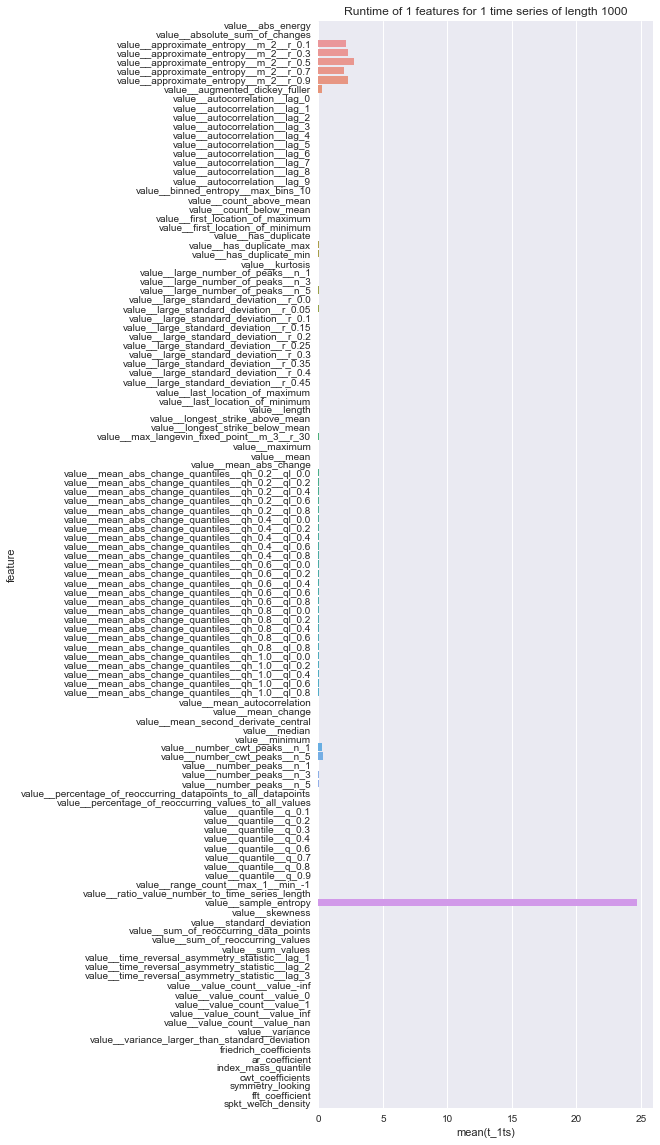

In [11]:
# Putting things into perspective
df = pd.concat([res, res2])

plt.figure(figsize=(6,20))
sns.barplot(y="feature", x="t_1ts", data=df)
plt.title("Runtime of 1 features for 1 time series of length 1000")
plt.show()

In [14]:
# we calculate how much many features cause 90% of the runtime 
r = df.t_1ts.copy()
r.sort_values(ascending=False)
r.cumsum() / r.sum()

value__abs_energy                                  0.000055
value__absolute_sum_of_changes                     0.000066
value__approximate_entropy__m_2__r_0.1             0.056952
value__approximate_entropy__m_2__r_0.3             0.117051
value__approximate_entropy__m_2__r_0.5             0.190272
value__approximate_entropy__m_2__r_0.7             0.243544
value__approximate_entropy__m_2__r_0.9             0.305215
value__augmented_dickey_fuller                     0.312051
value__autocorrelation__lag_0                      0.312101
value__autocorrelation__lag_1                      0.312157
value__autocorrelation__lag_2                      0.312211
value__autocorrelation__lag_3                      0.312264
value__autocorrelation__lag_4                      0.312315
value__autocorrelation__lag_5                      0.312371
value__autocorrelation__lag_6                      0.312423
value__autocorrelation__lag_7                      0.312478
value__autocorrelation__lag_8           

In [16]:
# we calculate how much many features cause 90% of the runtime 
r / r.sum()

value__abs_energy                                  0.000055
value__absolute_sum_of_changes                     0.000011
value__approximate_entropy__m_2__r_0.1             0.056885
value__approximate_entropy__m_2__r_0.3             0.060099
value__approximate_entropy__m_2__r_0.5             0.073221
value__approximate_entropy__m_2__r_0.7             0.053273
value__approximate_entropy__m_2__r_0.9             0.061670
value__augmented_dickey_fuller                     0.006837
value__autocorrelation__lag_0                      0.000049
value__autocorrelation__lag_1                      0.000057
value__autocorrelation__lag_2                      0.000054
value__autocorrelation__lag_3                      0.000052
value__autocorrelation__lag_4                      0.000051
value__autocorrelation__lag_5                      0.000055
value__autocorrelation__lag_6                      0.000052
value__autocorrelation__lag_7                      0.000055
value__autocorrelation__lag_8           

In [17]:
# sample_entropy and approximate_entropy make up for most of the runtime